In [52]:
!pip install transformers==4.24.0
!pip install simpletransformers==0.63.11
!pip install scikit-learn
!pip install tensorflow
!pip install dataset

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel
import tensorflow as tf

In [54]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import torch
import transformers
from transformers import BertTokenizer

In [55]:
torch.cuda.is_available()

True

In [56]:
from google.colab import drive
drive.mount('/content/drive/')
#
dir_dataset = ""
file_business = os.path.join(dir_dataset, "yelp_academic_dataset_business.json")
file_review = os.path.join(dir_dataset, "yelp_academic_dataset_review.json")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [57]:
%cd /content/drive/MyDrive/Yelp_Data

/content/drive/MyDrive/Yelp_Data


In [58]:
''' Read in the data - copied from my code in using machine learning algorithms'''
def json_df (file_name):
  counter = 0
  recorder = []

  for chunk in pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=1000):
      recorder.append(chunk)

      ''' #For smaller sized chunks to test code
      if counter == 5:
          break
      '''
      counter += 1
      if counter % 1000 == 0:
          print(counter)

  df_review = pd.concat(recorder)
  print("df_review made")
  return df_review

In [59]:
from sklearn.utils import resample

def undersample(df, group_size=20000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group,
                                     replace=False,
                                     n_samples=group_size,
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [60]:
%time df_all = json_df(file_review)

1000
2000
3000
4000
5000
6000
df_review made
CPU times: user 1min 50s, sys: 4.92 s, total: 1min 55s
Wall time: 2min 34s


In [101]:
df_review = df_all.copy()
#df_review = undersample(df_review)

In [104]:
df_review['labels'] = df_review['stars'].apply(lambda x: 1 if x > 3 else 0)
df_review = df_review[['text', 'labels']]

In [105]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_review, test_size=500000,random_state=42, shuffle=True)
df_train, df_dev = train_test_split(df_train, test_size=500000, random_state=42, shuffle=True)

In [67]:
# Function to tokenize the texts
def tokenize(df):
    return tokenizer(df['text'], padding='max_length', truncation=True, max_length=128)

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from datasets import load_dataset
import torch

os.environ["WANDB_DISABLED"] = "true"

# Load the tokenizer and the model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


# Load your dataframe into a Hugging Face dataset
from datasets import Dataset

df_new = df_train[['text', 'labels']] # training
#df_new = df_new[:1000]

dataset = Dataset.from_pandas(df_new)

# Tokenize the dataset
dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split the dataset into a training and validation set
dataset = dataset.train_test_split(test_size=0.2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy='epoch',  # or 'epoch' if you want to evaluate at the end of each epoch
    save_steps = 10000,
    eval_steps = 10000,
    logging_dir='./logs',
)


# Create the Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test']
)

trainer.train()


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.o

Epoch,Training Loss,Validation Loss
1,0.256200,0.284929
2,0.191500,0.303741
3,0.100500,0.411019


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=10500, training_loss=0.20289573851085846, metrics={'train_runtime': 1240.6721, 'train_samples_per_second': 135.41, 'train_steps_per_second': 8.463, 'total_flos': 1.105066432512e+16, 'train_loss': 0.20289573851085846, 'epoch': 3.0})

In [ ]:
from datasets import Dataset

# Select the part of the dataframe you want to use for evaluation
test_eval = df_review[1000:1010]

# Convert the pandas DataFrame to a Hugging Face Dataset
test_eval = Dataset.from_pandas(test_eval)

# Tokenize the data and set the format
test_eval = test_eval.map(tokenize, batched=True, batch_size=len(test_eval))
test_eval.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [106]:
df_new = df_test[['text', 'labels']]
df_test_dataset = Dataset.from_pandas(df_new)
df_test_dataset = df_test_dataset.map(tokenize, batched=True, batch_size=len(dataset))

df_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

In [107]:
prediction_output = trainer.predict(df_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500000
  Batch size = 16


In [108]:
pred = prediction_output.predictions

y_pred = prediction_output.label_ids
pred_metrics = prediction_output.metrics

In [109]:
y = df_test['labels']
label = 'testing'
model_name = 'bert sentiment-only'

[0 1 1 ... 0 1 1]
testing Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    164529
           1     1.0000    1.0000    1.0000    335471

    accuracy                         1.0000    500000
   macro avg     1.0000    1.0000    1.0000    500000
weighted avg     1.0000    1.0000    1.0000    500000



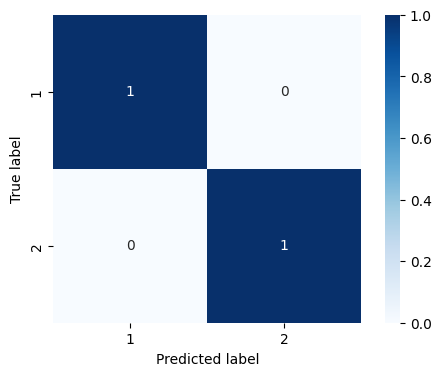

In [110]:
print(y_pred)
print(label + ' Set')
print("Accuracy:", accuracy_score(y, y_pred))
print()

print(classification_report(y, y_pred, digits=4))
#df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'),range(1,6), range(1,6))
df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'),range(1,3), range(1,3))
plt.figure(figsize=(6,4))
ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.savefig(model_name + "_" + label.lower() + ".eps")
plt.show()
print()